In [19]:
import sys
import os
directory = os.path.abspath(os.path.dirname(os.getcwd()))
print(directory)
sys.path.append(directory)

import batman
import matplotlib.pyplot as plt
import numpy as np
from src.mcmc_model import WrappedMCMC
from src.utility.bayesian_parameter import Parameter
from matplotlib.ticker import MaxNLocator

/mnt/c/Users/nicho/Research/GitHub/erebus


In [44]:
params = None
transit_model = None
def physical_model(x, t_sec, fp, rp_rstar, a_rstar, b, per):	
	# Convert impact to inclination
	inc = np.rad2deg(np.arccos(b / a_rstar))

	global params
	global transit_model
	if params is None:
		params = batman.TransitParams()
		params.t0 = 0
		params.t_secondary = t_sec
		params.fp = fp * 1e-6
		params.rp = rp_rstar
		params.inc = inc
		params.per = per
		params.a = a_rstar  
		params.ecc = 0.0  # Fixed: circular orbit
		params.w = 90.0  # Fixed: circular orbit
		params.limb_dark = "quadratic"
		params.u = [0.3, 0.3]
		transit_model = batman.TransitModel(params, x, transittype="secondary")
	params.t_secondary = t_sec
	params.fp = fp * 1e-6
	flux_model = transit_model.light_curve(params)
	return (flux_model - params.fp) * 1e6 # ppm

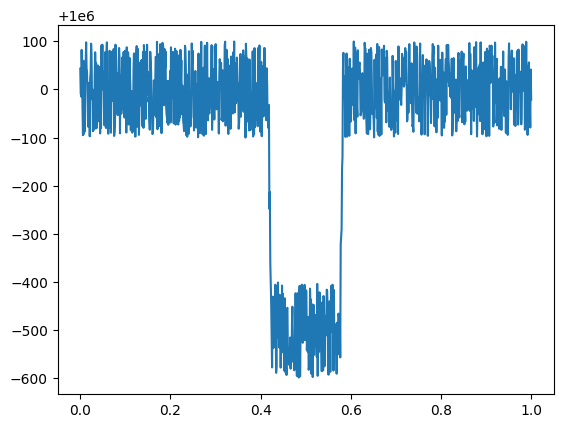

In [46]:
initial_values = [0.5, 500, 0.05, 10, 0, 5]
time = np.linspace(0, 1, 1000)
flux = physical_model(time, *initial_values) + (((2 * np.random.rand(len(time))) - 1) * 100)

plt.plot(time, flux)
plt.show()

In [47]:
mcmc = WrappedMCMC()
mcmc.add_parameter("t_sec", Parameter.uniform_prior(0.5, 0.3, 0.7))
mcmc.add_parameter("fp", Parameter.uniform_prior(0, -2000, 2000))
mcmc.add_parameter("rp_rstar", Parameter.fixed(0.05))
mcmc.add_parameter("a_rstar", Parameter.fixed(10))
mcmc.add_parameter("b", Parameter.fixed(0))
mcmc.add_parameter("per", Parameter.fixed(5))
mcmc.add_parameter("y_err", Parameter.fixed(100))
mcmc.set_method(physical_model)

mcmc.run(time, flux)

Initial guesses: [0.5, 0.0] variation: [0.04999999999999999, 500.0]
Initial likelihood: -7678.59153819962
Fitting for 2 parameters
Moved away from starting positions
Initial guesses shape: (2, 64, 2)
Mean likelihood after moving: -5699.238455096271
process chain 0


100%|█████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:55<00:00, 86.56it/s]


process chain 1


100%|█████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:54<00:00, 87.55it/s]


Rubin gelman convergence: [1.00003175 0.99999858] converged? True
Autocorr time: 30.742157716628 converged? True
Iterations: 10000 Max steps: 100000
Continue looping? False
Autocorr time: 30.742157716628


In [48]:
print(mcmc.results)

{'t_sec': 0.49990795150817346+/-0.00038380478722346845, 'fp': 502.2876627538943+/-7.901451897098923, 'rp_rstar': 0.05+/-0, 'a_rstar': 10.0+/-0, 'b': 0.0+/-0, 'per': 5.0+/-0, 'y_err': 100.0+/-0}


In [49]:
values = [mcmc.results[key].nominal_value for key in mcmc.results]
print(values)

[0.49990795150817346, 502.2876627538943, 0.05, 10.0, 0.0, 5.0, 100.0]


In [50]:
free_param_values = [mcmc.results[key].nominal_value for key in mcmc.get_free_params()]

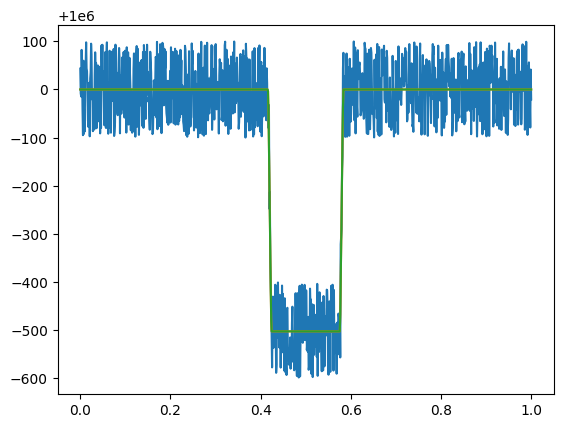

In [51]:
plt.plot(time, flux)
plt.plot(time, mcmc.evaluate_model(time, *free_param_values))
plt.plot(time, physical_model(time, *values[:-1]))
plt.show()

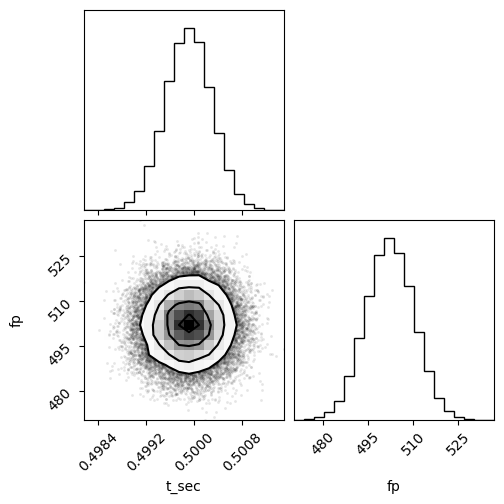

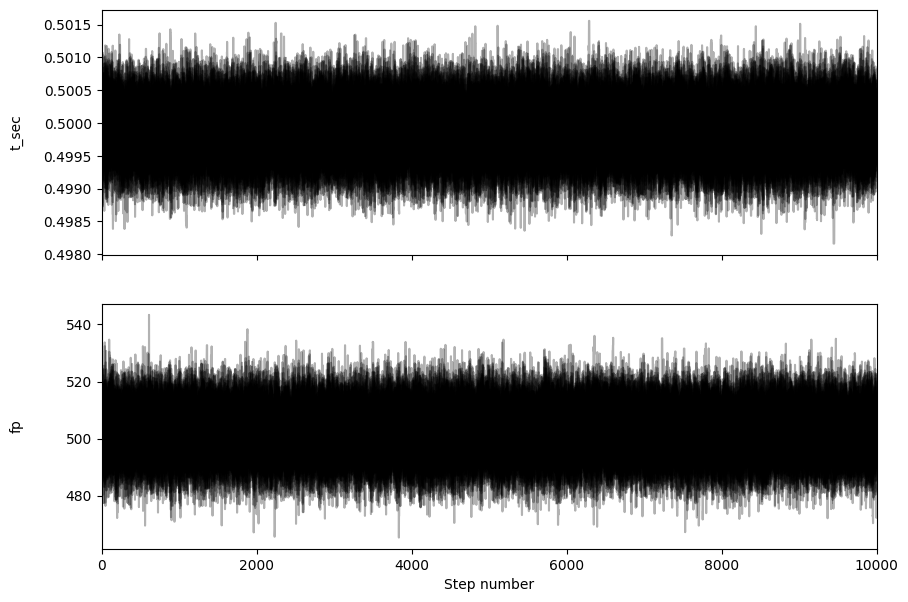

In [52]:
mcmc.corner_plot()
mcmc.chain_plot()